In this file, a report of local feature importance was created using the SHAP package and a waterfall chart. In addition, the waterfall function from the SHAP documentation was slightly reworked below, adapting under the project topic.

# Importing

In [1]:
import pandas as pd
import numpy as np
import joblib
import os

# for waterfall plot
import shap
import matplotlib
import matplotlib.pyplot as plt
import dataclasses
from typing import Union
import matplotlib.patches as mpatches

# for final report
import ipywidgets as widgets
from io import BytesIO


In [2]:
np.set_printoptions(suppress=False)

work_dir = r'C:\Users\krasavica\Desktop\Projekty - DS\python-project-ApartmentPriceAnalysis'
os.chdir(work_dir)

pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# Importing data previously stored in pipeline_for_training_data.ipynb file

model = joblib.load("production_pipeline_objects/trained_model.joblib")

X = pd.read_csv("3. Feature importance and report/feature_imp_data_X.csv", index_col = 0)
y = pd.read_csv("3. Feature importance and report/feature_imp_data_y.csv", index_col = 0).iloc[:, 0]

# Oryginal report

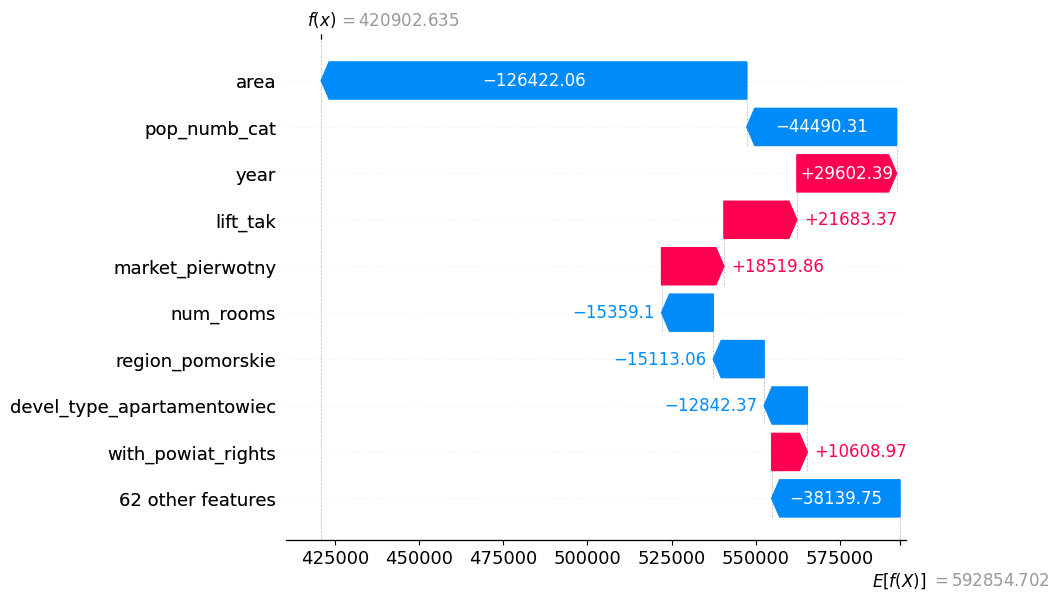

In [4]:
# Create a SHAP explainer and calculate base value
explainer = shap.TreeExplainer(model)
base_value = np.mean(y, axis=None)

# Calculate SHAP values for the example and wrap them in an Explanation object
shap_values_example = explainer.shap_values(X.iloc[0])
shap_values_example = shap.Explanation(values=shap_values_example,
                                       base_values=base_value,
                                       feature_names=X.columns)

# Show a SHAP waterfall plot for the single prediction
plt.rcParams['figure.facecolor'] = 'white' 
shap.plots.waterfall(shap_values_example, show=False)
plt.show()

# Adopting the watrefall plot

Adapting the waterfall function to the needs of the project:

* rounding numbers to thousands of PLN
* setting custom names, including features names
* adding a legend and shifting  the legend as needed
* shifting the y-axis to the left as needed
* combining categorical variables coded 0-1 into a single factor

In [5]:
base_value = np.mean(y, axis=None)
base_value_df = pd.DataFrame([base_value],
                             columns = ["base_value"])
base_value_df.to_csv("production_pipeline_objects/shap_base_value")

In [6]:
feature_names_pl = {'area': "Powierzchnia",
                    'num_rooms': "Liczba pokoi",
                    'parking': "Miejsce parkingowe",
                    'year': "Rok budowy",
                    'rent_cat': "Czynsz",
                    'number_floor_in_building':"Wysokość budynku",
                    'ap_floor': "Piętro",
                    'utilities': "Media",
                    'security': "Bezpieczeństwo",
                    'equipment': "Wyposażenie",
                    'add_inf': "Informacje dodatkowe",
                    'perks_balkon': "Balkon",
                    'perks_taras': "Taras",
                    'perks_ogródek': "Ogródek",
                    'pop_numb_cat': "Liczba mieszkańców",
                    'with_powiat_rights': "Miejscowość na prawach powiatu",
                    'pop_dens_cat': "Gęstość zaludnienia",
                    'ownership_status': "Forma własności",
                    'flat_condition': "Stan wykończenia",
                    'heating': "Ogrzewanie",
                    'market_pierwotny': "Rynek",
                    'ad_type_prywatny': "Ogłoszeniodawca",
                    'windows': "Materiał okien",
                    'lift_tak': "Winda",
                    'mater': "Materiał budynku",
                    'devel_type': "Typ zabudowy",
                    'region': "Województwo"}

In [7]:
labels = {
    "MAIN_EFFECT": "SHAP main effect value for\n%s",
    "INTERACTION_VALUE": "SHAP interaction value",
    "INTERACTION_EFFECT": "SHAP interaction value for\n%s and %s",
    "VALUE": "SHAP value (impact on model output)",
    "GLOBAL_VALUE": "mean(|SHAP value|) (average impact on model output magnitude)",
    "VALUE_FOR": "SHAP value for\n%s",
    "PLOT_FOR": "SHAP plot for %s",
    "FEATURE": "Feature %s",
    "FEATURE_VALUE": "Feature value",
    "FEATURE_VALUE_LOW": "Low",
    "FEATURE_VALUE_HIGH": "High",
    "JOINT_VALUE": "Joint SHAP value",
    "MODEL_OUTPUT": "Model output value",
}

RGBColorType = Union[tuple[float, float, float], str]
RGBAColorType = Union[
    str,  # "none" or "#RRGGBBAA"/"#RGBA" hex strings
    tuple[float, float, float, float],
    # 2 tuple (color, alpha) representations, not infinitely recursive
    # RGBColorType includes the (str, float) tuple, even for RGBA strings
    tuple[RGBColorType, float],
    # (4-tuple, float) is odd, but accepted as the outer float overriding A of 4-tuple
    tuple[tuple[float, float, float, float], float],
]

ColorType = Union[RGBColorType, RGBAColorType, np.ndarray]

@dataclasses.dataclass
class StyleConfig:
    """A complete set of configuration options for matplotlib-based shap plots."""

    primary_color_positive: ColorType
    primary_color_negative: ColorType
    secondary_color_positive: ColorType
    secondary_color_negative: ColorType
    hlines_color: ColorType
    vlines_color: ColorType
    text_color: ColorType
    tick_labels_color: ColorType

    def asdict(self):
        return dataclasses.asdict(self)

    
_shap_defaults = StyleConfig(
    primary_color_positive=shap.plots.colors.red_rgb,
    primary_color_negative=shap.plots.colors.blue_rgb,
    secondary_color_positive=shap.plots.colors.light_red_rgb,
    secondary_color_negative=shap.plots.colors.light_blue_rgb,
    hlines_color="#cccccc",
    vlines_color="#bbbbbb",
    text_color="white",
    tick_labels_color="#999999",
)

def load_default_style() -> StyleConfig:
    """Load the default style configuration."""
    # In future, this could allow reading from a persistent config file, like matplotlib rcParams.
    return _shap_defaults

_STYLE = load_default_style()

def get_style() -> StyleConfig:
    """Return all currently active global style configuration options."""
    return _STYLE

#from .. import Explanation
#from ..utils import format_value
#from ._labels import labels
#from ._style import get_style

# TODO: If we make a JS version of this plot then we could let users click on a bar and then see the dependence
# plot that is associated with that feature get overlaid on the plot...it would quickly allow users to answer
# why a feature is pushing down or up. Perhaps the best way to do this would be with an ICE plot hanging off
# of the bar...
def waterfall(shap_values, max_display=10, show=True):
    """Plots an explanation of a single prediction as a waterfall plot.

    The SHAP value of a feature represents the impact of the evidence provided by that feature on the model's
    output. The waterfall plot is designed to visually display how the SHAP values (evidence) of each feature
    move the model output from our prior expectation under the background data distribution, to the final model
    prediction given the evidence of all the features.

    Features are sorted by the magnitude of their SHAP values with the smallest
    magnitude features grouped together at the bottom of the plot when the number of
    features in the models exceeds the ``max_display`` parameter.

    Parameters
    ----------
    shap_values : Explanation
        A one-dimensional :class:`.Explanation` object that contains the feature values and SHAP values to plot.

    max_display : int
        The maximum number of features to display (default is 10).

    show : bool
        Whether :external+mpl:func:`matplotlib.pyplot.show()` is called before returning.
        Setting this to ``False`` allows the plot to be customized further after it
        has been created, returning the current axis via plt.gca().

    Examples
    --------
    See `waterfall plot examples <https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html>`_.

    """
    
    style = get_style()
    # Turn off interactive plot
    if show is False:
        plt.ioff()

    # make sure the input is an Explanation object
    if not isinstance(shap_values, shap.Explanation):
        emsg = "The waterfall plot requires an `Explanation` object as the `shap_values` argument."
        raise TypeError(emsg)

    # make sure we only have a single explanation to plot
    sv_shape = shap_values.shape
    if len(sv_shape) != 1:
        emsg = (
            "The waterfall plot can currently only plot a single explanation, but a "
            f"matrix of explanations (shape {sv_shape}) was passed! Perhaps try "
            "`shap.plots.waterfall(shap_values[0])` or for multi-output models, "
            "try `shap.plots.waterfall(shap_values[0, 0])`."
        )
        raise ValueError(emsg)

    base_values = shap_values.base_values.iloc[0]
    features = shap_values.display_data if shap_values.display_data is not None else shap_values.data
    feature_names = shap_values.feature_names
    feature_names = [feature_names_pl.get(name, name) for name in feature_names]
    lower_bounds = getattr(shap_values, "lower_bounds", None)
    upper_bounds = getattr(shap_values, "upper_bounds", None)
    values = shap_values.values

    # unwrap pandas series
    if isinstance(features, pd.Series):
        if feature_names is None:
            feature_names = list(features.index)
        features = features.values

    # fallback feature names
    if feature_names is None:
        feature_names = np.array([labels["FEATURE"] % str(i) for i in range(len(values))])

    # init variables we use for tracking the plot locations
    num_features = min(max_display, len(values))
    row_height = 0.5
    rng = range(num_features - 1, -1, -1)
    order = np.argsort(-np.abs(values))
    pos_lefts = []
    pos_inds = []
    pos_widths = []
    pos_low = []
    pos_high = []
    neg_lefts = []
    neg_inds = []
    neg_widths = []
    neg_low = []
    neg_high = []
    loc = base_values + values.sum()
    yticklabels = ["" for _ in range(num_features + 1)]

    # size the plot based on how many features we are plotting
    plt.gcf().set_size_inches(10, num_features * row_height + 1.5)

    # see how many individual (vs. grouped at the end) features we are plotting
    if num_features == len(values):
        num_individual = num_features
    else:
        num_individual = num_features - 1

    # compute the locations of the individual features and plot the dashed connecting lines
    for i in range(num_individual):
        sval = values[order[i]]
        loc -= sval
        if sval >= 0:
            pos_inds.append(rng[i])
            pos_widths.append(sval)
            if lower_bounds is not None:
                pos_low.append(lower_bounds[order[i]])
                pos_high.append(upper_bounds[order[i]])
            pos_lefts.append(loc)
        else:
            neg_inds.append(rng[i])
            neg_widths.append(sval)
            if lower_bounds is not None:
                neg_low.append(lower_bounds[order[i]])
                neg_high.append(upper_bounds[order[i]])
            neg_lefts.append(loc)
        if num_individual != num_features or i + 4 < num_individual:
            plt.plot(
                [loc, loc],
                [rng[i] - 1 - 0.4, rng[i] + 0.4],
                color=style.vlines_color,
                linestyle="--",
                linewidth=0.5,
                zorder=-1,
            )
        if features is None:
            yticklabels[rng[i]] = feature_names[order[i]]
        else:
            if np.issubdtype(type(features[order[i]]), np.number):
                yticklabels[rng[i]] = (
                    shap.utils.format_value(float(features[order[i]]), "%0.03f") + " = " + feature_names[order[i]]
                )
            else:
                yticklabels[rng[i]] = str(features[order[i]]) + " = " + str(feature_names[order[i]])

    # add a last grouped feature to represent the impact of all the features we didn't show
    if num_features < len(values):
        yticklabels[0] = "%d pozostałe czynniki" % (len(values) - num_features + 1)
        remaining_impact = base_values - loc
        if remaining_impact < 0:
            pos_inds.append(0)
            pos_widths.append(-remaining_impact)
            pos_lefts.append(loc + remaining_impact)
        else:
            neg_inds.append(0)
            neg_widths.append(-remaining_impact)
            neg_lefts.append(loc + remaining_impact)

    points = (
        pos_lefts
        + list(np.array(pos_lefts) + np.array(pos_widths))
        + neg_lefts
        + list(np.array(neg_lefts) + np.array(neg_widths))
    )
    dataw = np.max(points) - np.min(points)

    # draw invisible bars just for sizing the axes
    label_padding = np.array([0.1 * dataw if w < 1 else 0 for w in pos_widths])
    plt.barh(
        pos_inds,
        np.array(pos_widths) + label_padding + 0.02 * dataw,
        left=np.array(pos_lefts) - 0.01 * dataw,
        color=style.primary_color_positive,
        alpha=0,
    )
    label_padding = np.array([-0.1 * dataw if -w < 1 else 0 for w in neg_widths])
    plt.barh(
        neg_inds,
        np.array(neg_widths) + label_padding - 0.02 * dataw,
        left=np.array(neg_lefts) + 0.01 * dataw,
        color=style.primary_color_negative,
        alpha=0,
    )

    # define variable we need for plotting the arrows
    head_length = 0.08
    bar_width = 0.8
    xlen = plt.xlim()[1] - plt.xlim()[0]
    fig = plt.gcf()
    ax = plt.gca()
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width = bbox.width
    bbox_to_xscale = xlen / width
    hl_scaled = bbox_to_xscale * head_length
    renderer = fig.canvas.get_renderer()

    # draw the positive arrows
    txt_obj_pos_arrows = []
    for i in range(len(pos_inds)):
        dist = pos_widths[i]
        arrow_obj = plt.arrow(
            pos_lefts[i],
            pos_inds[i],
            max(dist - hl_scaled, 0.000001),
            0,
            head_length=min(dist, hl_scaled),
            color=style.primary_color_positive,
            width=bar_width,
            head_width=bar_width,
        )

        if pos_low is not None and i < len(pos_low):
            plt.errorbar(
                pos_lefts[i] + pos_widths[i],
                pos_inds[i],
                xerr=np.array([[pos_widths[i] - pos_low[i]], [pos_high[i] - pos_widths[i]]]),
                ecolor=style.secondary_color_positive,
            )

        txt_obj = plt.text(
            pos_lefts[i] + 0.5 * dist,
            pos_inds[i],
            f"{np.round(pos_widths[i]/1000, 1)}K PLN",
            horizontalalignment="center",
            verticalalignment="center",
            color=style.text_color,
            fontsize=12,
        )
        text_bbox = txt_obj.get_window_extent(renderer=renderer)
        arrow_bbox = arrow_obj.get_window_extent(renderer=renderer)

        # if the text overflows the arrow then draw it after the arrow
        if (text_bbox.width + 5) > arrow_bbox.width:
            txt_obj.remove()

            txt_obj = plt.text(
                pos_lefts[i] + (5 / 72) * bbox_to_xscale + dist,
                pos_inds[i],
                f"{np.round(pos_widths[i]/1000, 1)}K PLN",
                horizontalalignment="left",
                verticalalignment="center",
                color=style.primary_color_positive,
                fontsize=12,
            )
            txt_obj_x_axes = pos_lefts[i] + (5 / 72) * bbox_to_xscale + dist
            text_obj_dist = dist*(text_bbox.width + 5)/arrow_bbox.width
            txt_obj_pos_arrows.append(txt_obj_x_axes + text_obj_dist)

    # draw the negative arrows
    txt_obj_neg_arrows = []
    for i in range(len(neg_inds)):
        dist = neg_widths[i]

        arrow_obj = plt.arrow(
            neg_lefts[i],
            neg_inds[i],
            -max(-dist - hl_scaled, 0.000001),
            0,
            head_length=min(-dist, hl_scaled),
            color=style.primary_color_negative,
            width=bar_width,
            head_width=bar_width,
        )

        if neg_low is not None and i < len(neg_low):
            plt.errorbar(
                neg_lefts[i] + neg_widths[i],
                neg_inds[i],
                xerr=np.array([[neg_widths[i] - neg_low[i]], [neg_high[i] - neg_widths[i]]]),
                ecolor=style.secondary_color_negative,
            )

        txt_obj = plt.text(
            neg_lefts[i] + 0.5 * dist,
            neg_inds[i],
            f"{np.round(neg_widths[i]/1000, 1)}K PLN",
            horizontalalignment="center",
            verticalalignment="center",
            color=style.text_color,
            fontsize=12,
        )
        text_bbox = txt_obj.get_window_extent(renderer=renderer)
        arrow_bbox = arrow_obj.get_window_extent(renderer=renderer)

        # if the text overflows the arrow then draw it after the arrow
        if (text_bbox.width + 5) > arrow_bbox.width:
            txt_obj.remove()

            txt_obj = plt.text(
                neg_lefts[i] - (5 / 72) * bbox_to_xscale + dist,
                neg_inds[i],
                f"{np.round(neg_widths[i]/1000, 1)}K PLN",
                horizontalalignment="right",
                verticalalignment="center",
                color=style.primary_color_negative,
                fontsize=12,
            )
            
            txt_obj_x_axes = neg_lefts[i] - (5 / 72) * bbox_to_xscale + dist
            text_obj_dist = dist*(text_bbox.width + 5)/arrow_bbox.width
            
            txt_obj_neg_arrows.append(txt_obj_x_axes + text_obj_dist)
        

    # draw the y-ticks twice, once in gray and then again with just the feature names in black
    # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ytick_pos = list(range(num_features)) + list(np.arange(num_features) + 1e-8)
    plt.yticks(ytick_pos, yticklabels[:-1] + [label.split("=")[-1] for label in yticklabels[:-1]], fontsize=13)

    # put horizontal lines for each feature row
    for i in range(num_features):
        plt.axhline(i, color=style.hlines_color, lw=0.5, dashes=(1, 5), zorder=-1)

    # mark the prior expected value and the model prediction
    plt.axvline(base_values, 0, 1 / num_features, color=style.vlines_color, linestyle="--", linewidth=0.5, zorder=-1)
    fx = base_values + values.sum()
    plt.axvline(fx, 0, 1, color=style.vlines_color, linestyle="--", linewidth=0.5, zorder=-1)

    # clean up the main axis
    plt.gca().xaxis.set_ticks_position("bottom")
    plt.gca().yaxis.set_ticks_position("none")
    plt.gca().spines["right"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["left"].set_visible(False)
    ax.tick_params(labelsize=13)
    # plt.xlabel("\nModel output", fontsize=12)
    
    # setting limits od axis
    if len(txt_obj_neg_arrows)!=0:
        if min(txt_obj_neg_arrows) < ax.get_xlim()[0]:
            ax.set_xlim(min(txt_obj_neg_arrows), ax.get_xlim()[1])
            
    if len(txt_obj_pos_arrows)!=0:
        if max(txt_obj_pos_arrows) > ax.get_xlim()[1]:
            ax.set_xlim(ax.get_xlim()[0], max(txt_obj_pos_arrows))
            
        
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, _: f"{x:,.0f}".replace(",", " ")))
    
    # draw the E[f(X)] tick mark
    xmin, xmax = ax.get_xlim()
    ax2 = ax.twiny()
    ax2.set_xlim(xmin, xmax)
    ax2.set_xticks(
        [base_values, base_values + 1e-8]
    )  # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    base_values_str = f"{base_values:,.0f}".replace(",", " ")
    ax2.set_xticklabels(["\nPrzeciętna wartość\nmieszkania na rynku", f"\n\n = {base_values_str} PLN"], fontsize=12, ha="left")

    # draw the f(x) tick mark
    ax3 = ax2.twiny()
    ax3.set_xlim(xmin, xmax)
    # The 1e-8 is so matplotlib 3.3 doesn't try and collapse the ticks
    ax3.set_xticks([base_values + values.sum(), base_values + values.sum() + 1e-8])
    fx_str = f"{fx:,.0f}".replace(",", " ")
    ax3.set_xticklabels(["Wartość przewidziana\nprzez model", f" = {fx_str} PLN"], fontsize=12, ha="left")
    tick_labels = ax3.xaxis.get_majorticklabels()
    tick_labels[0].set_ha("right")
    tick_labels[0].set_transform(
        tick_labels[0].get_transform() + matplotlib.transforms.ScaledTranslation(-1 / 72.0, 0, fig.dpi_scale_trans)
    )
    tick_labels[1].set_ha("left")
    tick_labels[1].set_transform(
        tick_labels[1].get_transform() + matplotlib.transforms.ScaledTranslation(1 / 72.0, 0, fig.dpi_scale_trans)
    )
    tick_labels[1].set_color(style.tick_labels_color)
    ax3.spines["right"].set_visible(False)
    ax3.spines["top"].set_visible(False)
    ax3.spines["left"].set_visible(False)

    # adjust the position of the E[f(X)] = x.xx label
    tick_labels = ax2.xaxis.get_majorticklabels()
    ax2.get_xticklabels()[0].set_ha('left')
    tick_labels[0].set_ha("right")
    tick_labels[0].set_transform(
        tick_labels[0].get_transform() + matplotlib.transforms.ScaledTranslation(-1 / 72.0, 0, fig.dpi_scale_trans)
    )
    tick_labels[1].set_ha("left")
    tick_labels[1].set_transform(
        tick_labels[1].get_transform()
        + matplotlib.transforms.ScaledTranslation(1 / 72.0, -1 / 72.0, fig.dpi_scale_trans)
    )

    tick_labels[1].set_color(style.tick_labels_color)
    ax2.spines["right"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax2.spines["left"].set_visible(False)
    
    # color the y tick labels that have the feature values as gray
    # (these fall behind the black ones with just the feature name)
    tick_labels = ax.yaxis.get_majorticklabels()
    for i in range(num_features):
        tick_labels[i].set_color(style.tick_labels_color)


    # Dodaj legendę dla strzałek
    positive_patch = mpatches.Patch(color=get_style().primary_color_positive, label="Czynnik wpływa na większą\ncenę mieszkania")
    negative_patch = mpatches.Patch(color=get_style().primary_color_negative, label="Czynnik wpływa na mniejszą\ncenę mieszkania")
    
    if ax.get_xlim()[0] < fx-(ax.get_xlim()[1]-ax.get_xlim()[0])*0.1:
        plt.legend(handles=[positive_patch, negative_patch],
                   loc='lower left',
                   fontsize=10,
                   frameon=True,
                   bbox_to_anchor=(-0.3, 1),
                   borderaxespad=0.5)
    else:
        plt.legend(handles=[positive_patch, negative_patch],
                   loc='lower left',
                   fontsize=10,
                   frameon=True,
                   bbox_to_anchor=(0.8, 1),
                   borderaxespad=0.5)
    
    if show:
        plt.show()
    else:
        return plt.gca()

In [8]:
def feature_imp_report(row, model):
    """
    Generates a SHAP waterfall plot and explanation object for a single prediction.

    Parameters:
    -----------
    row : pandas.DataFrame
        A single-row DataFrame representing the instance for which SHAP values are computed.
    model : trained model
        A trained tree-based model compatible with SHAP (e.g., XGBoost, LightGBM).

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated SHAP waterfall plot as a matplotlib figure.
    shap_values_plot : shap.Explanation
        The SHAP explanation object containing the summarized feature contributions.
    """

    # Initialize a SHAP TreeExplainer for the given model
    explainer = shap.TreeExplainer(model)

    # Load precomputed base value for SHAP from file (mean prediction on training data)
    base_value = pd.read_csv("production_pipeline_objects/shap_base_value", index_col=0).iloc[0]

    # Compute SHAP values for the input row
    shap_value = explainer.shap_values(row)[0]

    # Create DataFrame with SHAP values for individual features
    shap_value_df = pd.DataFrame([shap_value], columns=row.columns)

    # Combine SHAP values for one-hot encoded categorical features into single group values
    for sum_feature in ['ownership_status', 'flat_condition', 'heating', 'ad_type', 'windows',
                        'mater', 'devel_type', 'region', 'utilities', 'security', 'equipment',
                        'add_inf']:
        # Find all columns that belong to the current group
        features = [col for col in shap_value_df.columns if col.startswith(sum_feature)]
        # Sum their SHAP values and assign to the grouped feature name
        shap_value_df[sum_feature] = shap_value_df[features].sum().sum()
        # Drop the original one-hot columns
        shap_value_df = shap_value_df.drop(columns=features)

    # Create a SHAP Explanation object with the aggregated SHAP values
    shap_values_plot = shap.Explanation(
        values=shap_value_df.values[0],
        base_values=base_value,
        feature_names=shap_value_df.columns
    )

    # Generate the SHAP waterfall plot
    plt.rcParams['figure.facecolor'] = 'white'
    fig = waterfall(shap_values_plot, show=False).get_figure()
    fig.set_size_inches(12, 7.5)  # Set plot size

    return fig, shap_values_plot


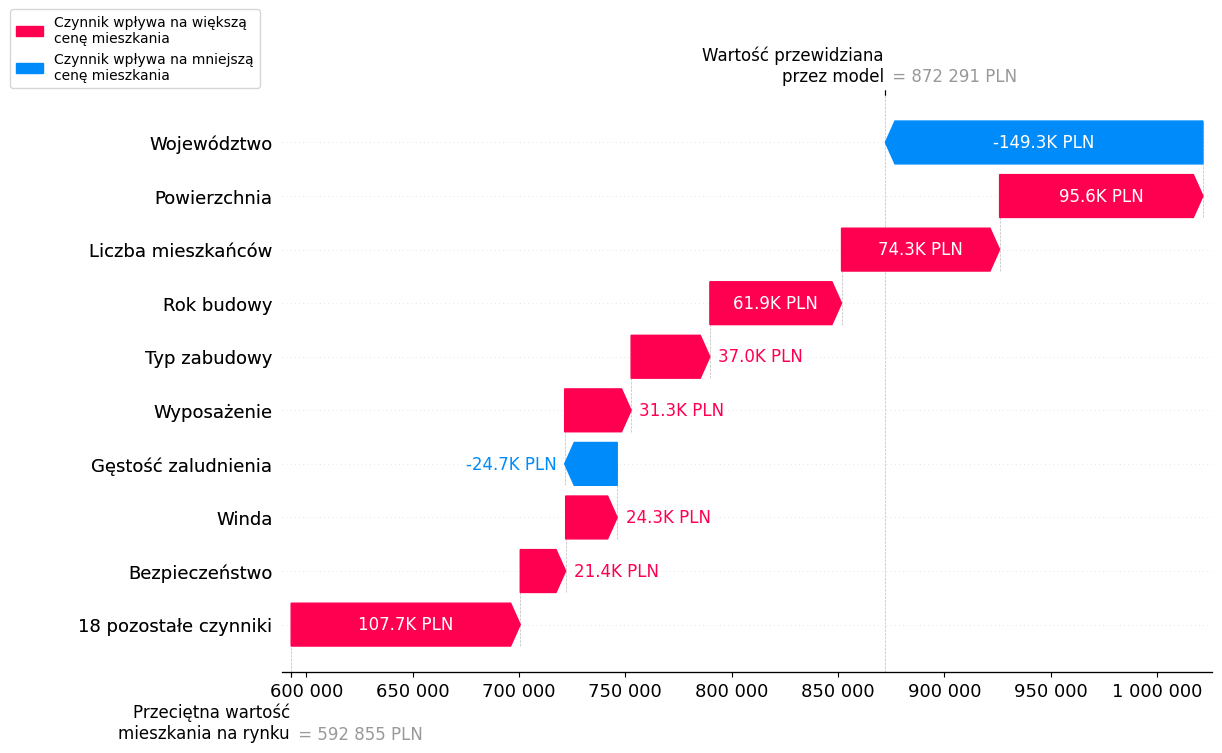

In [9]:
# Applying feature_imp_report function
f_imp_obj, shap_values = feature_imp_report(X.iloc[[1]], model)
plt.show(f_imp_obj)

# Complete prediction report

In [10]:
def pred_result_show(y, shap_values):
    
    """
    Displays a summary text visualization comparing the predicted and actual apartment prices.

    Parameters:
    -----------
    y : pandas.Series
        A single-value Series containing the actual listing price (if available).
    shap_values : shap.Explanation
        SHAP Explanation object containing the base value and SHAP contributions for the prediction.

    Returns:
    --------
    fig : matplotlib.figure.Figure
        A matplotlib figure displaying the comparison text.
    """

    # Compute the predicted price by summing SHAP contributions and the base value
    y_pred = float(shap_values.base_values.iloc[0]) + sum(shap_values.values)

    # Create a horizontal figure with no axes for text display
    fig, ax = plt.subplots(figsize=(14, 0.8))
    ax.axis('off')


    if y:
        # Format the actual price
        y_str = f"Cena mieszkania w ogłoszeniu: {y:,.0f} PLN".replace(",", " ")

        # Calculate % difference between actual and predicted price
        y_def = (y / y_pred - 1) * 100
        if y_def > 0:
            y_def_str = f"Mieszkanie jest o {y_def:,.2f}% droższe niż podobne mieszkania".replace(",", " ")
        else:
            y_def_str = f"Mieszkanie jest o {-y_def:,.2f}% tańsze niż podobne mieszkania".replace(",", " ")

        # Calculate % difference between actual and base (mean) price
        y_def_base = (y / float(shap_values.base_values.iloc[0]) - 1) * 100
        if y_def_base > 0:
            y_def_base_str = f"Mieszkanie jest o {y_def_base:,.2f}% droższe od średniej ceny na rynku".replace(",", " ")
        else:
            y_def_base_str = f"Mieszkanie jest o {-y_def_base:,.2f}% tańsze od średniej ceny na rynku".replace(",", " ")

    else:
        # Case when actual price is not provided
        y_str = "Nie podano ceny w ogłoszeniu"
        y_def_str = ""
        y_def_base_str = ""

    # Format predicted price
    y_pred_str = f"Cena mieszkania wg modelu: {y_pred:,.0f} PLN".replace(",", " ")

    # Display all formatted strings as text in the figure
    ax.text(
        0.02, 0.5,
        f"{y_str}\n{y_pred_str}\n{y_def_str}\n{y_def_base_str}",
        fontsize=16,
        verticalalignment='center',
        horizontalalignment='left'
    )

    return fig

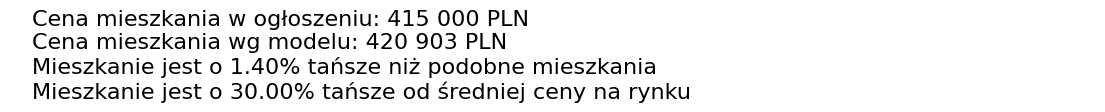

In [11]:
# Applying pred_result_show function
f_imp_obj, shap_values = feature_imp_report(X.iloc[[0]], model)
plt.close()
res_obj = pred_result_show(y.iloc[0], shap_values)
plt.show(res_obj)

In [12]:
def run_display(res_obj, f_imp_obj):
    
    """
    Converts two matplotlib figures into image widgets and displays them vertically in a Jupyter Notebook.

    Parameters:
    -----------
    res_obj : matplotlib.figure.Figure
        The first figure to be displayed, typically showing model prediction results.
    f_imp_obj : matplotlib.figure.Figure
        The second figure to be displayed, typically showing feature importance or SHAP explanation.

    Returns:
    --------
    None
        The function directly displays the figures using IPython's display system.
    """

    # Convert the first figure to a PNG image in memory
    tmpfile_res = BytesIO()
    res_obj.savefig(tmpfile_res, format='png', bbox_inches='tight')
    tmpfile_res.seek(0)
    plt.close()  # Close to free up memory

    # Convert the second figure to a PNG image in memory
    tmpfile_f_imp = BytesIO()
    f_imp_obj.savefig(tmpfile_f_imp, format='png', bbox_inches='tight')
    tmpfile_f_imp.seek(0)
    plt.close()  # Close to free up memory
    
    # Create a widget to display the first image
    res_widget = widgets.Image(
        value=tmpfile_res.getvalue(), format='png',
        layout=widgets.Layout(width='100%', height='auto', margin='0px')
    )

    # Create a widget to display the second image
    f_imp_widget = widgets.Image(
        value=tmpfile_f_imp.getvalue(), format='png',
        layout=widgets.Layout(width='100%', height='auto')
    )

    # Display both images vertically using a VBox layout
    display(widgets.VBox([res_widget, f_imp_widget]))


In [13]:
# Applying run_display function
f_imp_obj, shap_values = feature_imp_report(X.iloc[[0]], model)
res_obj = pred_result_show(y.iloc[0], shap_values)
run_display(res_obj, f_imp_obj)

# Testing

In [14]:
for i in range(25):    
    f_imp_obj, shap_values = feature_imp_report(X.iloc[[i]], model)
    res_obj = pred_result_show(y.iloc[i], shap_values)
    run_display(res_obj, f_imp_obj)